# Under ice chlorophyll-a, oxygen and nitrate analysis

### Import packages

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import seawater as sw
from soccom_functions import *
import pickle 
import datetime
import xarray as xr
import pandas as pd 
import plotly.graph_objs as go
import cmocean
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline 

### Read float data

For a single float

In [11]:
file_folder = "../../data/raw/SOCCOM_HiResQC_LIAR_21Dec2021_netcdf/" # specify directory relative to location of notebook
                # WGfloats
float_number = "5904471" #7900918 #9094/5904471 #5904397

files = sorted(glob.glob(file_folder+"/*"+float_number+"*.nc"))
print(files)
#files = sorted(glob.glob(file_folder+"/*.nc"))

['../../data/raw/SOCCOM_HiResQC_LIAR_21Dec2021_netcdf\\5904471_HRQC.nc']


### Loads and grids data from single float

In [12]:
#uses the function that reads and grids the data
FLOAT = grids_one_buoy(files[0],display_info = False, DO_ml_crit = 2.5, clear_short = True)

#the gridded data is located in the dictionary FLOAT.gr, and contains the following variables
print(FLOAT.gr.keys())
print(FLOAT.raw_bg.keys())
#some of them are standard and others related to thorpe scales and mixing, and you also have geopotential anomalies (gpa) integrated between 500 and 1500 m (gpa_500_1500)

print("This float is WMO code: %s"%(FLOAT.gr["WMO_code"]))

C:\Users\ccd1n18\OneDrive - University of Southampton\PhD\Projects\net_community_production\notebooks\FromBieito\soccom_functions.py:338: RuntimeWarning: Mean of empty slice
  self.gr["LT"][j,i] = np.nanmean(disp[jj]**2)**0.5


dict_keys(['depth', 'date', 'date_dt', 'Lon', 'Lat', 'code', 'WMO_code', 'Pressure', 'Temperature', 'Salinity', 'SA', 'CT', 'Sigma_theta', 'gamma_n', 'N2', 'PV', 'Oxygen', 'OxygenSat', 'Nitrate', 'DIC_LIAR', 'TALK_LIAR', 'pCO2_LIAR', 'Chl_a', 'Chl_a_corr', 'POC', 'LT', 'mld', 'mld_HT', 'mld_DO', 'LT_ml', 'LT_ov', 'LT_largest_ov', 'size_largest_ov', 'h_largest_ov', 'h_no_ov', 'gpa', 'gpa_500_1500', 'AOU'])
dict_keys(['Oxygen', 'OxygenSat', 'Nitrate', 'DIC_LIAR', 'TALK_LIAR', 'pCO2_LIAR', 'Chl_a', 'Chl_a_corr', 'POC'])
This float is WMO code: 5904471


## Initial plot of the float main variables and position

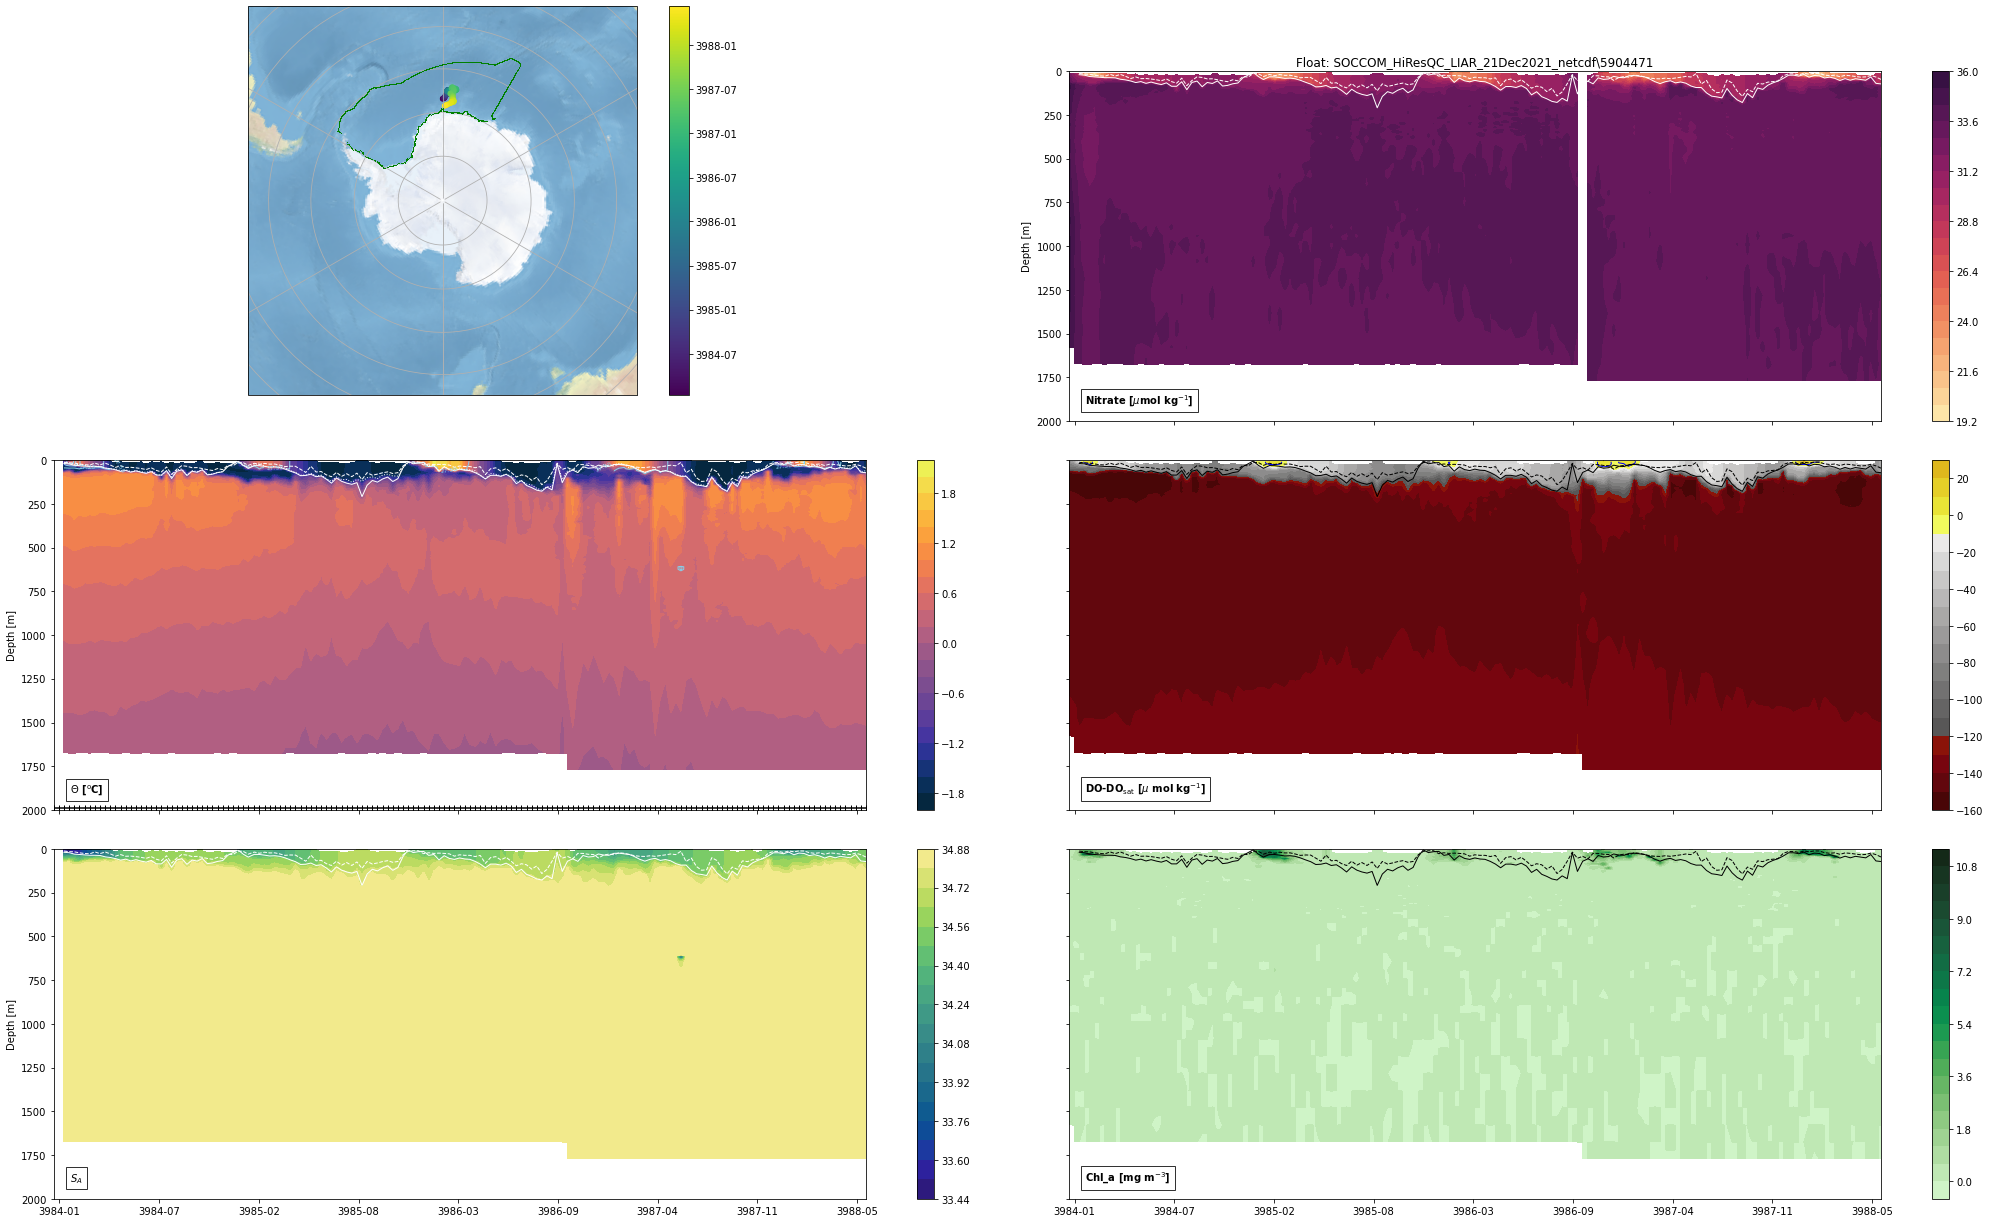

In [81]:
%matplotlib inline 
#qt
studyarea=pd.read_csv('../../data/processed/ANDREXbox.csv',header=None).values

#with this command you can have an overview of the float data 
FLOAT.plots_map_main_variables(studyarea, shows = True, saves = False)#,  ylim=  (600,0))
#FLOAT.plots_mixing_layer_profile(20, show = True)

#plt.plot(FLOAT.gr["date"],FLOAT.gr["gpa_500_1500"])

## Integrate chlorophyll 

Function for trapezoidal integration method:

In [14]:
# calculate the vertically integrated data column inventory using the composite trapezoidal rule
def integrate(zi, data, depth_range):
    n_profs = len(data)
    zi_start = abs(zi - depth_range[0]).argmin() # find location of start depth
    zi_end =  abs(zi - depth_range[1]).argmin() # find location of end depth
    zi_struct = np.ones((n_profs, 1)) * zi[zi_start : zi_end] # add +1 to get the 200m value
    data = data[:, zi_start : zi_end] # add +1 to get the 200m value
    col_inv = []
    for n in range(0, len(data)):
        col_inv.append(np.trapz(data[n,:][~np.isnan(data[n,:])], zi_struct[n,:][~np.isnan(data[n,:])]))
    return col_inv

### Using a fixed lower limit
Shallowest = 0m

Deepest = 200m (following previous studies of Nitrate drawdown, where 200m was the deepest MLD for all the floats in the region/SO)

In [15]:
# Interpolate/get data set up
zi = np.arange(0, 2005, 5) # 5 = 400 depth intervals between 0m to 2000m
    #or zi=self.gr["depth"] #which = np.arange(0,2000+dz,dz)
chl_int = FLOAT.gr["Chl_a"] # interpolated chl values across zi depth intervals for all profiles
#print(chl_int.shape)
#print(chl_int.T.shape)

# Integrate chl - total chl in upper 200m
upperlim=0
lowerlim=200

chl_intr200 = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated nitrate values between 0m-200m 
#print(chl_intr200)
#len(chl_intr200)

Text(0.5, 0, 'Profile Number')

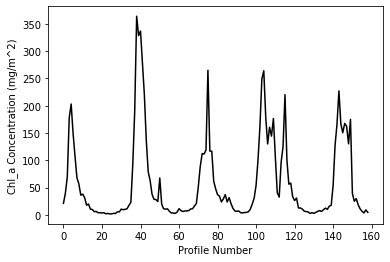

In [21]:
#Plot
plt.figure()
plt.plot(chl_intr200, c='black')
plt.ylabel('Chl_a Concentration (mg/m^2)')
plt.xlabel('Profile Number')

### Using the deepest MLD seen by the float

In [24]:
# Integrate chl - total chl in upper ML - to deepest MLD seen by float
upperlim=0
lowerlim=np.nanmax(FLOAT.gr["mld"])
print("Deepest mixed layer: %1.0f m"%(lowerlim))

chl_intr_dMLD = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated nitrate values between 0m-200m 
#print(chl_intr_dMLD)
#len(chl_intr_dMLD)

Deepest mixed layer: 209 m


Text(0.5, 0, 'Profile Number')

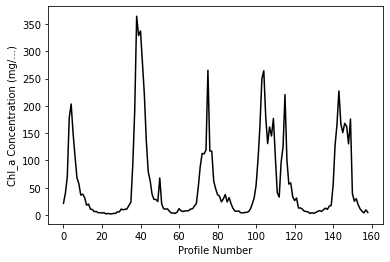

In [114]:
#Plot
plt.figure()
plt.plot(chl_intr_dMLD, c='black')
plt.ylabel('Chl_a Concentration (mg/...)')
plt.xlabel('Profile Number')

### Using the profile specific MLD

In [49]:
H2=FLOAT.gr["mld"]
nz= len(H2)
print(nz)
print(H2.shape)

159
(159,)


In [65]:
# using MLD calculated for each individual profile
chl_T=chl_int.T # the interpolated chl from FLOAT.gr

# calculate the vertically integrated data column inventory using the composite trapezoidal rule
def integrate_wMLD(zi, data, start_depth, MLD):
    #n_profs = len(data)
    zi_start = abs(zi - start_depth).argmin() # find index of start depth
    zi_end =  abs(zi - MLD).argmin() # find index of end depth
    zi_struct = zi[zi_start : zi_end] # add +1 to get the 200m value
    data = data[zi_start : zi_end] # add +1 to get the 200m value
    col_inv = []
    #for n in range(0, len(data)):
    col_inv.append(np.trapz(data[:][~np.isnan(data[:])], zi_struct[:][~np.isnan(data[:])]))
    return col_inv

dint_chla = np.full( nz, np.nan )

print(chl_T.shape)
print(FLOAT.gr["depth"].shape)

for i in range(nz): #nz = length H2 (mld array) = number of profiles
    #print(i)
    if np.isnan(H2[i]):
        dint_chla[i] = np.nan # in float used to write code, there were some nan for MLD because of no salinity values recorded
    else:
        jh = np.where( FLOAT.gr["depth"]>= H2[i])[0][0] # gets the depth index for the maxmum mixed layer
        #print(jh)
        lowerlim=H2[jh]
        data=chl_T[i,:]
        #print(len(data))
        #print(lowerlim)
        dint_chla[i] = np.array(integrate_wMLD(zi, data, upperlim, lowerlim)) # integrate interpolated nitrate values between 0m-specificMLD
    
#print(dint_chla)

(159, 401)
(401,)


Text(0.5, 0, 'Profile Number')

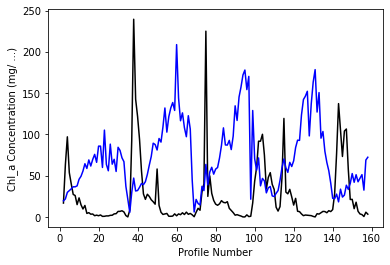

In [113]:
#Plot
plt.figure()
plt.plot(dint_chla, c='black')
plt.plot(H2, c='blue')
plt.ylabel('Chl_a Concentration (mg/ ...)')
plt.xlabel('Profile Number')
#plt.zlabel('MLD')

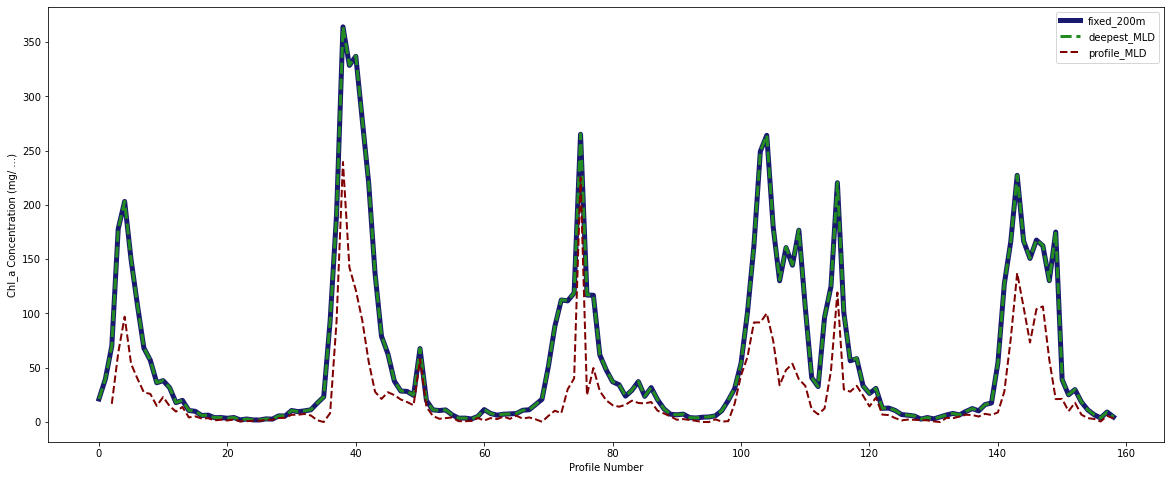

In [112]:
fig, ax = plt.subplots(figsize = (20, 8))
#chl_intr200, chl_intr_dMLD, dint_chla
fixed_200m,=plt.plot(chl_intr200, c='midnightblue',ls='-',lw=5)
deepest_MLD,=plt.plot(chl_intr_dMLD, c='forestgreen',ls='--',lw=3)
profile_MLD,=plt.plot(dint_chla, c='maroon',ls='--',lw=2)
ax.legend([fixed_200m, deepest_MLD,profile_MLD], ['fixed_200m', 'deepest_MLD', 'profile_MLD'])
#plt.gca().invert_yaxis()
plt.ylabel('Chl_a Concentration (mg/ ...)')
plt.xlabel('Profile Number')
#plt.title('Nitrate profile #1 from {0}'.format(timestamps[0]));
plt.show()

### The entire water column
Useful to see how different this is from integrating only in the ML - how much chl is being recorded below the mixed layer/below a fixed depth?

And should that be used to adjust the chl_a readings? - i.e. if floats are always recording chl at depth, does that need to shift/calibrate readings??

In [74]:
# Interpolate/get data set up
zi = np.arange(0, 2005, 5) # 5 = 400 depth intervals between 0m to 2000m
    #or zi=self.gr["depth"] #which = np.arange(0,2000+dz,dz)
chl_int = FLOAT.gr["Chl_a"] # interpolated chl values across zi depth intervals for all profiles
#print(chl_int.shape)
#print(chl_int.T.shape)

# Integrate chl - total chl in upper 200m
upperlim=0
lowerlim=2000

chl_intrWC = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated nitrate values between 0m-200m 
#print(chl_intr200)
#len(chl_intr200)

Text(0.5, 0, 'Profile Number')

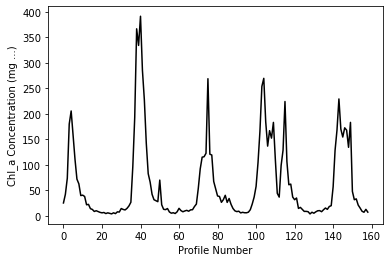

In [111]:
#Plot
plt.figure()
plt.plot(chl_intrWC, c='black')
plt.ylabel('Chl_a Concentration (mg ...)')
plt.xlabel('Profile Number')

## All together

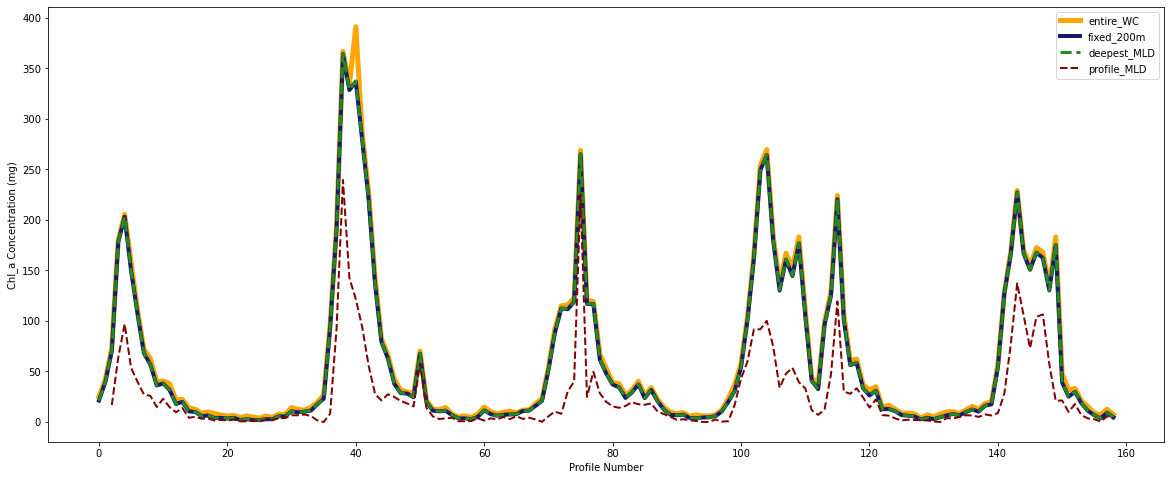

In [109]:
fig, ax = plt.subplots(figsize = (20, 8))
#chl_intr200, chl_intr_dMLD, dint_chla
entire_WC,=plt.plot(chl_intrWC, c='orange',ls='-',lw=5)
fixed_200m,=plt.plot(chl_intr200, c='midnightblue',ls='-',lw=4)
deepest_MLD,=plt.plot(chl_intr_dMLD, c='forestgreen',ls='--',lw=3)
profile_MLD,=plt.plot(dint_chla, c='maroon',ls='--',lw=2)
ax.legend([entire_WC,fixed_200m, deepest_MLD,profile_MLD], ['entire_WC','fixed_200m', 'deepest_MLD', 'profile_MLD'])
#plt.gca().invert_yaxis()
plt.ylabel('Chl_a Concentration (mg)')
plt.xlabel('Profile Number')
#plt.title('Nitrate profile #1 from {0}'.format(timestamps[0]));
plt.show()

##### As you can see, using profile MLD gives a lot lower values - and looking back at the time-depth plots, can see that there are chl hotspots below the MLD ... DCM??

#### Difference between mixed layer chl and water column chl

In [17]:
chl_200WC_diff=chl_intrWC-chl_intr200
print(chl_200WC_diff)

[ 4.07605921  2.60683504  3.84050936  1.92889028  2.36466975  8.13945701
  3.24295324  3.89151244  5.83073382  3.60642394  2.43193583  6.28596216
  3.89789737  2.53811273  3.49091046  2.73393863  2.66166442  3.6617328
  4.40439861  2.72611872  2.46591043  2.42670687  2.56264108  3.11286773
  2.91102085  2.0301216   3.06532932  1.76781818  2.17971978  1.95931168
  3.71029407  3.04475881  1.294565    3.43337212  2.00858714  3.51497094
  3.15165121  2.11941713  2.58349432  5.55248293 54.31585359  6.69810443
  6.68727083  5.61891819  3.64739972  3.36941549  4.45065647  3.09106877
  1.63852003  3.27938316  2.43163176  1.94620576  1.60870821  1.62855034
  3.18566661  0.98763201  1.67379891  2.50410091  1.7974326   2.75611931
  3.28056674  2.51080962  1.70661717  2.42976604  3.27331464  1.23381293
  0.90520512  0.71302499  2.11938232  2.05836467  2.54235242  3.93750652
  2.60403392  4.2602353   3.74596597  3.74205004  3.93947544  2.50004769
  5.59761898  5.26369097  1.91291138  3.63224943  2.

## Identify which profiles were under ice

In [108]:
for i in range(nz):
    test=np.isnan(FLOAT.gr["Chl_a"][0:5,i])
    #print(test)
    #print(np.isnan(test))
    #jh = np.where( FLOAT.gr["depth"]<= 25)
    #print(jh)

## How much of the annual chl was present under ice?
* Integrate profile chl total to get austral total
* Integrate chl for under ice profiles only
* Calculate proportion/% of under-ice chl per year

## What is happening to the chl when the satellite isn't seeing the ice-free waters (after March)?

## Export integrated chl timeseries for plotting alongside local NPP data in matlab (or import values from matlab to here)

## Calculate max (and mean in ML) chl in profiles

In [6]:
H = np.nanmax(FLOAT.gr["mld"]) # calculates the maximum ML
print("Deepest mixed layer: %1.0f m"%(H))

jh = np.where( FLOAT.gr["depth"]>= H)[0][0] # gets the depth index for the maxmum mixed layer ([0][0] requests the first instance - so the shallowest depth point that is greater or equal to MLD)

print(jh)
# maximum chl in water column
max_Chl_a = np.nanmax(FLOAT.gr["Chl_a"][:,:], axis = 0)
max_Chl_a_corr = np.nanmax(FLOAT.gr["Chl_a_corr"][:,:], axis = 0)
meanML_Chl_a = np.nanmean(FLOAT.gr["Chl_a_corr"][:jh,:], axis = 0)
sumML_Chl_a = np.nansum(FLOAT.gr["Chl_a"][:jh,:], axis = 0)

print(np.nanmax(max_Chl_a))
print(np.nanmax(max_Chl_a_corr))
print(sumML_Chl_a)


Deepest mixed layer: 209 m
42
10.93026146581811
3.6434204886060364
[ 4.37140591  8.18768673 14.4636425  37.57206903 42.55900865 31.26755207
 22.52199106 14.30875859 12.06040074  7.63292238  8.02790239  6.61474077
  3.76908864  4.13912797  2.24329909  2.06496027  1.24806063  1.32994757
  0.83793271  0.85740994  0.71364643  0.86891673  0.40919095  0.57756264
  0.42166559  0.40736734  0.60792531  0.58167592  1.1900182   1.16977965
  2.22458867  2.00320161  2.1537303   2.3607325   3.67717297  4.81246224
 19.15477444 40.5038697  76.81562272 69.1495371  70.30759979 58.1183209
 45.21230425 27.9176318  16.29116416 12.93582714  7.85211824  5.95072163
  5.83189742  5.05994895 14.20006316  4.04331004  2.32037191  2.18640582
  2.28812578  1.3737316   0.74311739  0.74673664  0.58433883  1.06820447
  2.34470071  1.62110714  1.32107131  1.49411631  1.55990877  1.63903448
  2.23038767  2.34879613  3.33848381  4.26069478 10.45050948 17.96876006
 23.34026225 23.12304058 24.78956454 55.22170891 23.961409

In [67]:
uplim=1
deeplim=100
lowlim=200 # check what values of chl_a there are deeper than 150m - 
            #there shouldn't be any, so may indicate some callibration error/uncertainty if there is, and need to correct for that
Uh = np.where( FLOAT.gr["depth"]>= uplim)[0][0]
Dh = np.where( FLOAT.gr["depth"]>= deeplim)[0][0]
Lh = np.where( FLOAT.gr["depth"]>= lowlim)[0][0]

In [68]:
#get time/dates
nt = FLOAT.gr["date"].size
dateDT = convert_time_to_date( FLOAT.gr["date"] )
year = np.full( nt, np.nan )
month = np.full(nt, np.nan)
for i in range(nt):
    year[i] = dateDT[i].year
    month[i] = dateDT[i].month

In [102]:
# calculate the vertically integrated data column inventory using the composite trapezoidal rule
def integrate(zi, data, depth_range):
    n_depths,n_profs=data.shape
    #n_profs = len(data)
    zi_start = abs(zi - depth_range[0]).argmin() # find location of start depth
    zi_end =  abs(zi - depth_range[1]).argmin() # find location of end depth
    zi_struct = np.ones((n_profs, 1)) * zi[zi_start : zi_end] # add +1 to get the 200m value
    data = data[ zi_start : zi_end,:] # add +1 to get the 200m value
    col_inv = []
    for n in range(0, n_profs):#len(data)):
        col_inv.append(np.trapz(data[:,n][~np.isnan(data[:,n])], zi_struct[n,:][~np.isnan(data[:,n])]))
    return col_inv
#np.trapz?
#print(len(FLOAT.gr["Nitrate"]))

In [105]:
# Interpolate nitrate and poc
zi = np.arange(0, 2005, 5) # 5 = 320 depth intervals between 0m to 1595m
#nitr_int = interpolate(zi, fd.Pressure[:, ::-1], fd.Nitrate[:, ::-1]) # interpolate nitrate values across zi depth intervals for all 188 profiles
# Integrate nitrate and poc - total nitrate in upper 200m
upperlim=1
lowerlim=200
nitr = np.array(integrate(zi, FLOAT.gr["Nitrate"], [upperlim, lowerlim])) # integrate interpolated nitrate values between 25m-200m 
print(np.round((nitr[40:60]/1000),4))
dint_Nitrate = np.nanmean(FLOAT.gr["Nitrate"][Uh:Lh,:], axis = 0)*H*(1027/1e6)
print(np.round((dint_Nitrate[40:60]),4))

print(len(nitr))
print(len(dint_Nitrate))
#print(np.diff(np.round((nitr[0:10]/1000),4)))
#print(np.diff(np.round((dint_Nitrate[0:10]),4)))

[5.8008 5.8399 5.5832 5.6195 5.6623 5.5569 5.5844 5.6824 5.6292 5.2495
 5.2375 5.318  5.3197 5.1464 5.2981 5.3283 5.5022 5.3935 5.4238 5.4176]
[4.4505 4.4814 4.4028 4.4308 4.4643 4.3833 4.4061 4.4822 4.4416 4.5067
 4.4974 4.5635 4.5654 4.552  4.5485 4.5741 4.5882 4.6294 4.6547 4.6494]
181
181


C:\Users\ccd1n18\AppData\Local\Temp/ipykernel_3640/640036355.py:9: RuntimeWarning: Mean of empty slice
  dint_Nitrate = np.nanmean(FLOAT.gr["Nitrate"][Uh:Lh,:], axis = 0)*H*(1027/1e6)


In [ ]:
print(FLOAT.gr["Nitrate"][Uh:Lh,179:])
np.trapz?
depths,profs=FLOAT.gr["Nitrate"].shape
print(profs)

[[        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [31.36840264         nan]
 [32.02021782         nan]
 [32.38251474         nan]
 [32.70443218         nan]
 [33.02634962         nan]
 [33.34826706         nan]
 [33.67018449         nan]
 [33.99210193         nan]
 [34.31401937         nan]
 [34.5291142          nan]
 [34.63050604         nan]
 [34.71794894         nan]
 [34.77500214         nan]
 [34.83205534         nan]
 [34.88910854         nan]
 [34.94106049         nan]
 [34.95087981         nan]
 

Signature: np.trapz(y, x=None, dx=1.0, axis=-1)
Docstring:
Integrate along the given axis using the composite trapezoidal rule.

Integrate `y` (`x`) along given axis.

Parameters
----------
y : array_like
    Input array to integrate.
x : array_like, optional
    The sample points corresponding to the `y` values. If `x` is None,
    the sample points are assumed to be evenly spaced `dx` apart. The
    default is None.
dx : scalar, optional
    The spacing between sample points when `x` is None. The default is 1.
axis : int, optional
    The axis along which to integrate.

Returns
-------
trapz : float
    Definite integral as approximated by trapezoidal rule.

See Also
--------
sum, cumsum

Notes
-----
Image [2]_ illustrates trapezoidal rule -- y-axis locations of points
will be taken from `y` array, by default x-axis distances between
points will be 1.0, alternatively they can be provided with `x` array
or with `dx` scalar.  Return value will be equal to combined area under
the red li

How much chl-a recorded below 150m?

In [17]:
deep_Chl_a = np.nanmax(FLOAT.gr["Chl_a_corr"][Lh:,:], axis = 0)
#max_Chl_a_corr = np.nanmax(FLOAT.gr["Chl_a_corr"][Uh:Dh,:], axis = 0)
#meanML_Chl_a = np.nanmean(FLOAT.gr["Chl_a_corr"][:jh,:], axis = 0)
print('Absolute maximum chl-a measurement below 150m:',np.round(np.nanmax(deep_Chl_a),5),'mg m^{-3}')
print('Average of the maximum chl-a measurement below 150m:',np.round(np.nanmean(deep_Chl_a),5),'mg m^{-3}')

Absolute maximum chl-a measurement below 150m: 0.2385 mg m^{-3}
Average of the maximum chl-a measurement below 150m: 0.00765 mg m^{-3}


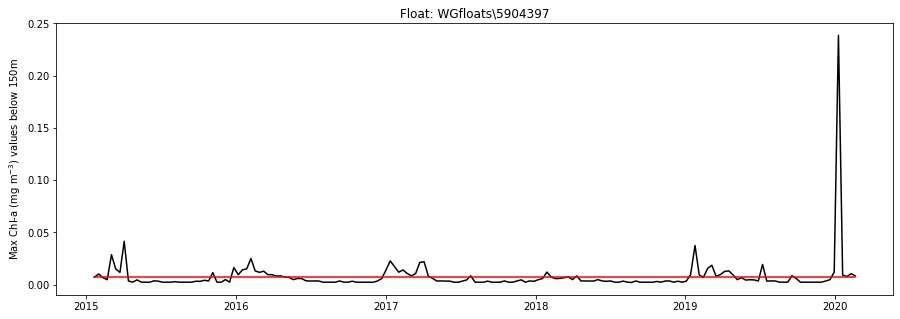

In [45]:
fig, ax = plt.subplots(figsize = (15,5), sharex = True)
#fig,(ax1,ax2)=plt.figure(figsize = (15,5))
plt.plot( FLOAT.gr["date_dt"], deep_Chl_a, "k" )
ax.set_ylabel( "Max Chl-a (mg m$^{-3}$) values below 150m" )
mean_deep_chl_a=[np.nanmean(deep_Chl_a)]*len(FLOAT.gr["date"])
plt.plot(FLOAT.gr["date_dt"], mean_deep_chl_a, "r")
ax.set_title("Float: %s"%(FLOAT.raw["code"]))

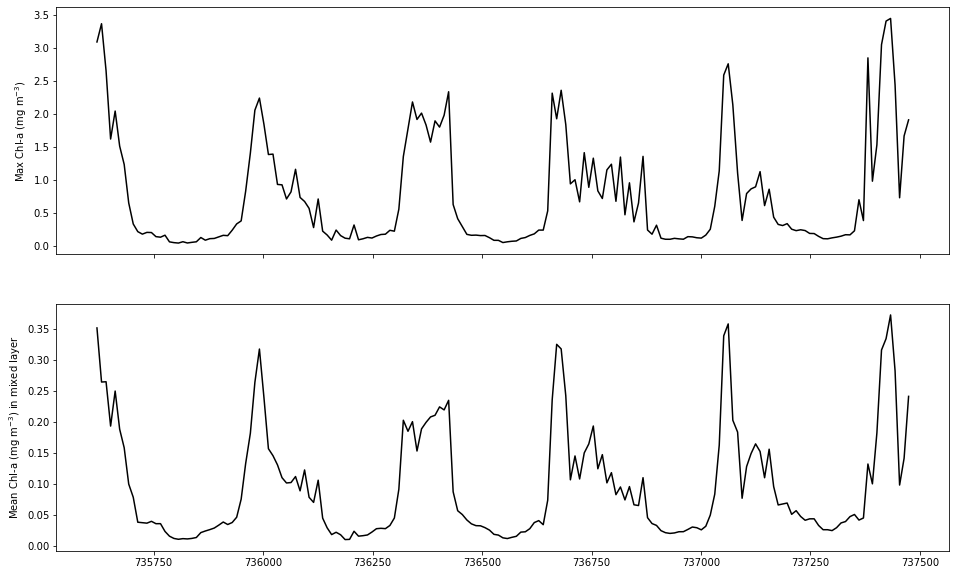

In [5]:
fig, ax = plt.subplots(2,1,figsize = (16,10), sharex = True)
ax[0].plot( FLOAT.gr["date"], max_Chl_a, "k" )
ax[0].set_ylabel( "Max Chl-a (mg m$^{-3}$)" )
ax[1].plot( FLOAT.gr["date"], meanML_Chl_a, "k" )
ax[1].set_ylabel( "Mean Chl-a (mg m$^{-3}$) in mixed layer" )
ax[1].format_xdata = mdates.DateFormatter('%Y-%m')
#ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

### Read in all floats from a directory

In [ ]:
#reads float data
file_folder = "../../data/raw/WGfloats/" # specify directory relative to location of notebook

files = sorted(glob.glob(file_folder+"/*.nc"))
print(files)

In [ ]:
for f_ix in range(0,len(files)):
    FLOAT = grids_one_buoy(files[f_ix],display_info = False, DO_ml_crit = 2.5, clear_short = True)
    #the gridded data is located in the dictionary FLOAT.gr, and contains the following variables
    print(FLOAT.gr.keys())
    #some of them are standard and others related to thorpe scales and mixing, and you also have geopotential anomalies (gpa) integrated between 500 and 1500 m (gpa_500_1500)
    print("This float is WMO code: %s"%(FLOAT.gr["WMO_code"]))
    
    NEPt,NEP_avgt,Uyeart=calc_NEP(FLOAT)
    
    str_t=FLOAT.gr["WMO_code"]+"_NEP"
    str_av=FLOAT.gr["WMO_code"]+"_NEPav"
    
    df = pd.DataFrame(NEPt, columns = [str_t], index = [Uyeart])
    NEPdf=pd.concat([NEPdf,df],axis=1)
    dfav = pd.DataFrame(NEP_avgt, columns = [str_av], index = [Uyeart])
    NEPavdf=pd.concat([NEPavdf,dfav],axis=1)
    
    
    
    #make a map of float trajectory
    #ax0 = fig.add_axes([0.10,0.67,0.3,0.3], projection = proj) #ax0 = fig.add_axes([0.10,0.1,0.7,0.7], projection = proj)
    #ax0.gridlines(draw_labels=False)
    #ax0.set_extent([-180, 180, -90, -45], crs.PlateCarree()) # originally -25 as north extent, will shorten to -45
    #ax0.stock_img()
    #cc = ax0.scatter(FLOAT.raw["Lon"], FLOAT.raw["Lat"], 20, c = FLOAT.raw["date"],transform = crs.PlateCarree(),)#-self.raw["date"][0])
    #loc = mdates.AutoDateLocator()
    #fig.colorbar(cc, ticks=loc,format=mdates.AutoDateFormatter(loc))
    #box = ax0.plot([studyarea[:,0]],[studyarea[:,1]],transform = crs.PlateCarree(),color='green', marker=',', linestyle='dashed',linewidth=1.5, markersize=1.5)
    

       
#print(NEPdf)
#print(NEPavdf)
plt.show()
NEP_nitrate=pd.concat([NEPdf,NEPavdf],axis=1)
print(NEP_nitrate)